In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=717bedc4fc99505c2acdc70074ac39e6a31e226c71ee346ad95595495155e22a
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import ta

In [4]:
def fetch_stock_data(ticker, start_date, end_date, interval='1d'):
    ticker = 'TATAMOTORS.NS'
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date, interval=interval)

    # Basic price and volume features
    basic_features = df[['Close', 'Volume', 'High', 'Low', 'Open']]

    # Fill NaN values
    basic_features = basic_features.ffill().bfill()

    return basic_features

In [5]:
class StockDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.FloatTensor(data)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return self.data[idx:idx+self.seq_length]

In [6]:
# Attention mechanism
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.multi_head_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)

    def forward(self, query, key, value, attn_mask=None):
        attn_output, attn_weights = self.multi_head_attn(query, key, value)
        return attn_output, attn_weights

# Enhanced Encoder with Attention
class EnhancedEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads=4):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = MultiHeadAttention(hidden_dim * 2, num_heads)
        self.mu_layer = nn.Linear(hidden_dim * 2, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim * 2, latent_dim)

    def forward(self, x):
        # LSTM encoding
        lstm_out, (h_n, _) = self.lstm(x)

        # Self-attention
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)

        # Global average pooling
        h = torch.mean(attn_out, dim=1)

        # Generate latent parameters
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)

        return mu, logvar, attn_out

In [7]:
class EnhancedDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, seq_length, num_heads=4):
        super().__init__()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.initial = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = MultiHeadAttention(hidden_dim * 2, num_heads)
        self.output = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, z):
        h = self.initial(z)
        h = h.unsqueeze(1).repeat(1, self.seq_length, 1)
        h, _ = self.lstm(h)

        # Self-attention
        attn_out, _ = self.attention(h, h, h)

        return self.output(attn_out)

In [8]:
# Diffusion process
class DiffusionProcess:
    def __init__(self, num_timesteps, device):
        self.num_timesteps = num_timesteps
        self.device = device
        # Linear beta schedule
        self.beta = torch.linspace(1e-4, 0.02, num_timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x0, t):
        """Add noise to the data"""
        t = t.to(self.device)
        alpha_t = self.alpha_bar[t].view(-1, 1)  # Reshape for broadcasting
        eps = torch.randn_like(x0, device=self.device)
        return torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * eps, eps

    def reverse_diffusion(self, model, xt, t):
        """Remove noise from the data"""
        t = t.to(self.device)
        predicted_noise = model(xt, t)
        alpha_t = self.alpha_bar[t].view(-1, 1)
        beta_t = self.beta[t].view(-1, 1)

        mean = (1 / torch.sqrt(alpha_t)) * (xt - (beta_t / torch.sqrt(1 - alpha_t)) * predicted_noise)
        if t > 0:
            noise = torch.randn_like(xt, device=self.device)
            sigma_t = torch.sqrt(beta_t)
            return mean + sigma_t * noise
        else:
            return mean

In [9]:
# Enhanced DVA Model
class EnhancedDVA(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_length, num_timesteps, device):
        super().__init__()
        self.encoder = EnhancedEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = EnhancedDecoder(latent_dim, hidden_dim, input_dim, seq_length)
        self.diffusion = DiffusionProcess(num_timesteps, device)
        self.seq_length = seq_length
        self.latent_dim = latent_dim
        self.device = device

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar, attn_features = self.encoder(x)
        z = self.reparameterize(mu, logvar)

        # Apply diffusion process
        t = torch.randint(0, self.diffusion.num_timesteps, (x.size(0),), device=self.device)
        noisy_z, noise = self.diffusion.forward_diffusion(z, t)

        # Decode
        reconstruction = self.decoder(noisy_z)

        return reconstruction, mu, logvar, noise, attn_features

In [10]:
# Visualization utilities
class StockVisualizer:
    def __init__(self, model, scaler, device):
        self.model = model
        self.scaler = scaler
        self.device = device

    def plot_predictions(self, test_data, feature_names):
        """Plot actual vs predicted values for each feature"""
        self.model.eval()
        with torch.no_grad():
            test_tensor = torch.FloatTensor(test_data).unsqueeze(0).to(self.device)
            reconstruction, _, _, _, _ = self.model(test_tensor)

            # Convert predictions back to original scale
            pred_numpy = reconstruction.cpu().numpy().squeeze()
            actual_numpy = test_data

            pred_unscaled = self.scaler.inverse_transform(pred_numpy)
            actual_unscaled = self.scaler.inverse_transform(actual_numpy)

            # Create subplots for each feature
            n_features = len(feature_names)
            fig, axes = plt.subplots(n_features, 1, figsize=(15, 4*n_features))

            for i, (ax, feature) in enumerate(zip(axes, feature_names)):
                ax.plot(actual_unscaled[:, i], label='Actual', color='blue')
                ax.plot(pred_unscaled[:, i], label='Predicted', color='red', linestyle='--')
                ax.set_title(f'{feature} - Actual vs Predicted')
                ax.legend()
                ax.grid(True)

            plt.tight_layout()
            return fig

    def plot_attention_heatmap(self, test_data):
        """Plot attention weights heatmap"""
        self.model.eval()
        with torch.no_grad():
            test_tensor = torch.FloatTensor(test_data).unsqueeze(0).to(self.device)
            _, _, _, _, attn_features = self.model(test_tensor)

            # Create attention heatmap
            plt.figure(figsize=(12, 8))
            sns.heatmap(attn_features.cpu().numpy().squeeze(),
                       cmap='viridis',
                       xticklabels=False,
                       yticklabels=False)
            plt.title('Attention Weights Heatmap')
            plt.xlabel('Sequence Position')
            plt.ylabel('Hidden Dimensions')
            return plt.gcf()

    def plot_latent_space(self, test_loader):
        """Plot 2D visualization of latent space"""
        self.model.eval()
        latent_vectors = []

        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(self.device)
                mu, logvar, _ = self.model.encoder(batch)
                z = self.model.reparameterize(mu, logvar)
                latent_vectors.append(z.cpu().numpy())

        latent_vectors = np.concatenate(latent_vectors, axis=0)

        # Use PCA or t-SNE for visualization if latent_dim > 2
        if latent_vectors.shape[1] > 2:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            latent_vectors = pca.fit_transform(latent_vectors)

        plt.figure(figsize=(10, 8))
        plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], alpha=0.5)
        plt.title('Latent Space Visualization')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        return plt.gcf()

In [11]:
# Enhanced training function with visualization
def train_dva_with_visualization(model, train_loader, test_loader, optimizer, num_epochs, device, feature_names, scaler):
    model.train()
    visualizer = StockVisualizer(model, scaler, device)  # Pass the scaler here
    training_losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            reconstruction, mu, logvar, noise, _ = model(batch)

            # Reconstruction loss (MSE)
            recon_loss = F.mse_loss(reconstruction, batch)

            # KL divergence
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            # Total loss
            loss = recon_loss + 0.1 * kl_loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        training_losses.append(avg_loss)

        # Generate visualizations at the end of training
        if (epoch + 1) == num_epochs:
            model.eval()  # Set to evaluation mode
            with torch.no_grad():
                test_batch = next(iter(test_loader))
                test_batch = test_batch.to(device)
                visualizer.plot_predictions(test_batch.cpu().numpy()[0], feature_names)
                # visualizer.plot_attention_heatmap(test_batch.cpu().numpy()[0])
                # visualizer.plot_latent_space(test_loader)
                plt.show()
            model.train()  # Set back to training mode

        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

        # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Epoch [1/30], Average Loss: 0.2206
Epoch [2/30], Average Loss: 0.0777
Epoch [3/30], Average Loss: 0.0698
Epoch [4/30], Average Loss: 0.0670
Epoch [5/30], Average Loss: 0.0658
Epoch [6/30], Average Loss: 0.0698
Epoch [7/30], Average Loss: 0.0667
Epoch [8/30], Average Loss: 0.0692
Epoch [9/30], Average Loss: 0.0657
Epoch [10/30], Average Loss: 0.0672
Epoch [11/30], Average Loss: 0.0649
Epoch [12/30], Average Loss: 0.0648
Epoch [13/30], Average Loss: 0.0665
Epoch [14/30], Average Loss: 0.0663
Epoch [15/30], Average Loss: 0.0650
Epoch [16/30], Average Loss: 0.0651
Epoch [17/30], Average Loss: 0.0634
Epoch [18/30], Average Loss: 0.0637
Epoch [19/30], Average Loss: 0.0641
Epoch [20/30], Average Loss: 0.0637
Epoch [21/30], Average Loss: 0.0641
Epoch [22/30], Average Loss: 0.0638
Epoch [23/30], Average Loss: 0.0642
Epoch [24/30], Average Loss: 0.0636
Epoch [25/30], Average Loss: 0.0636
Epoch [26/30], Average Loss: 0.0639
Epoch [27/30], Average Loss: 0.0652
Epoch [28/30], Average Loss: 0.0643
E

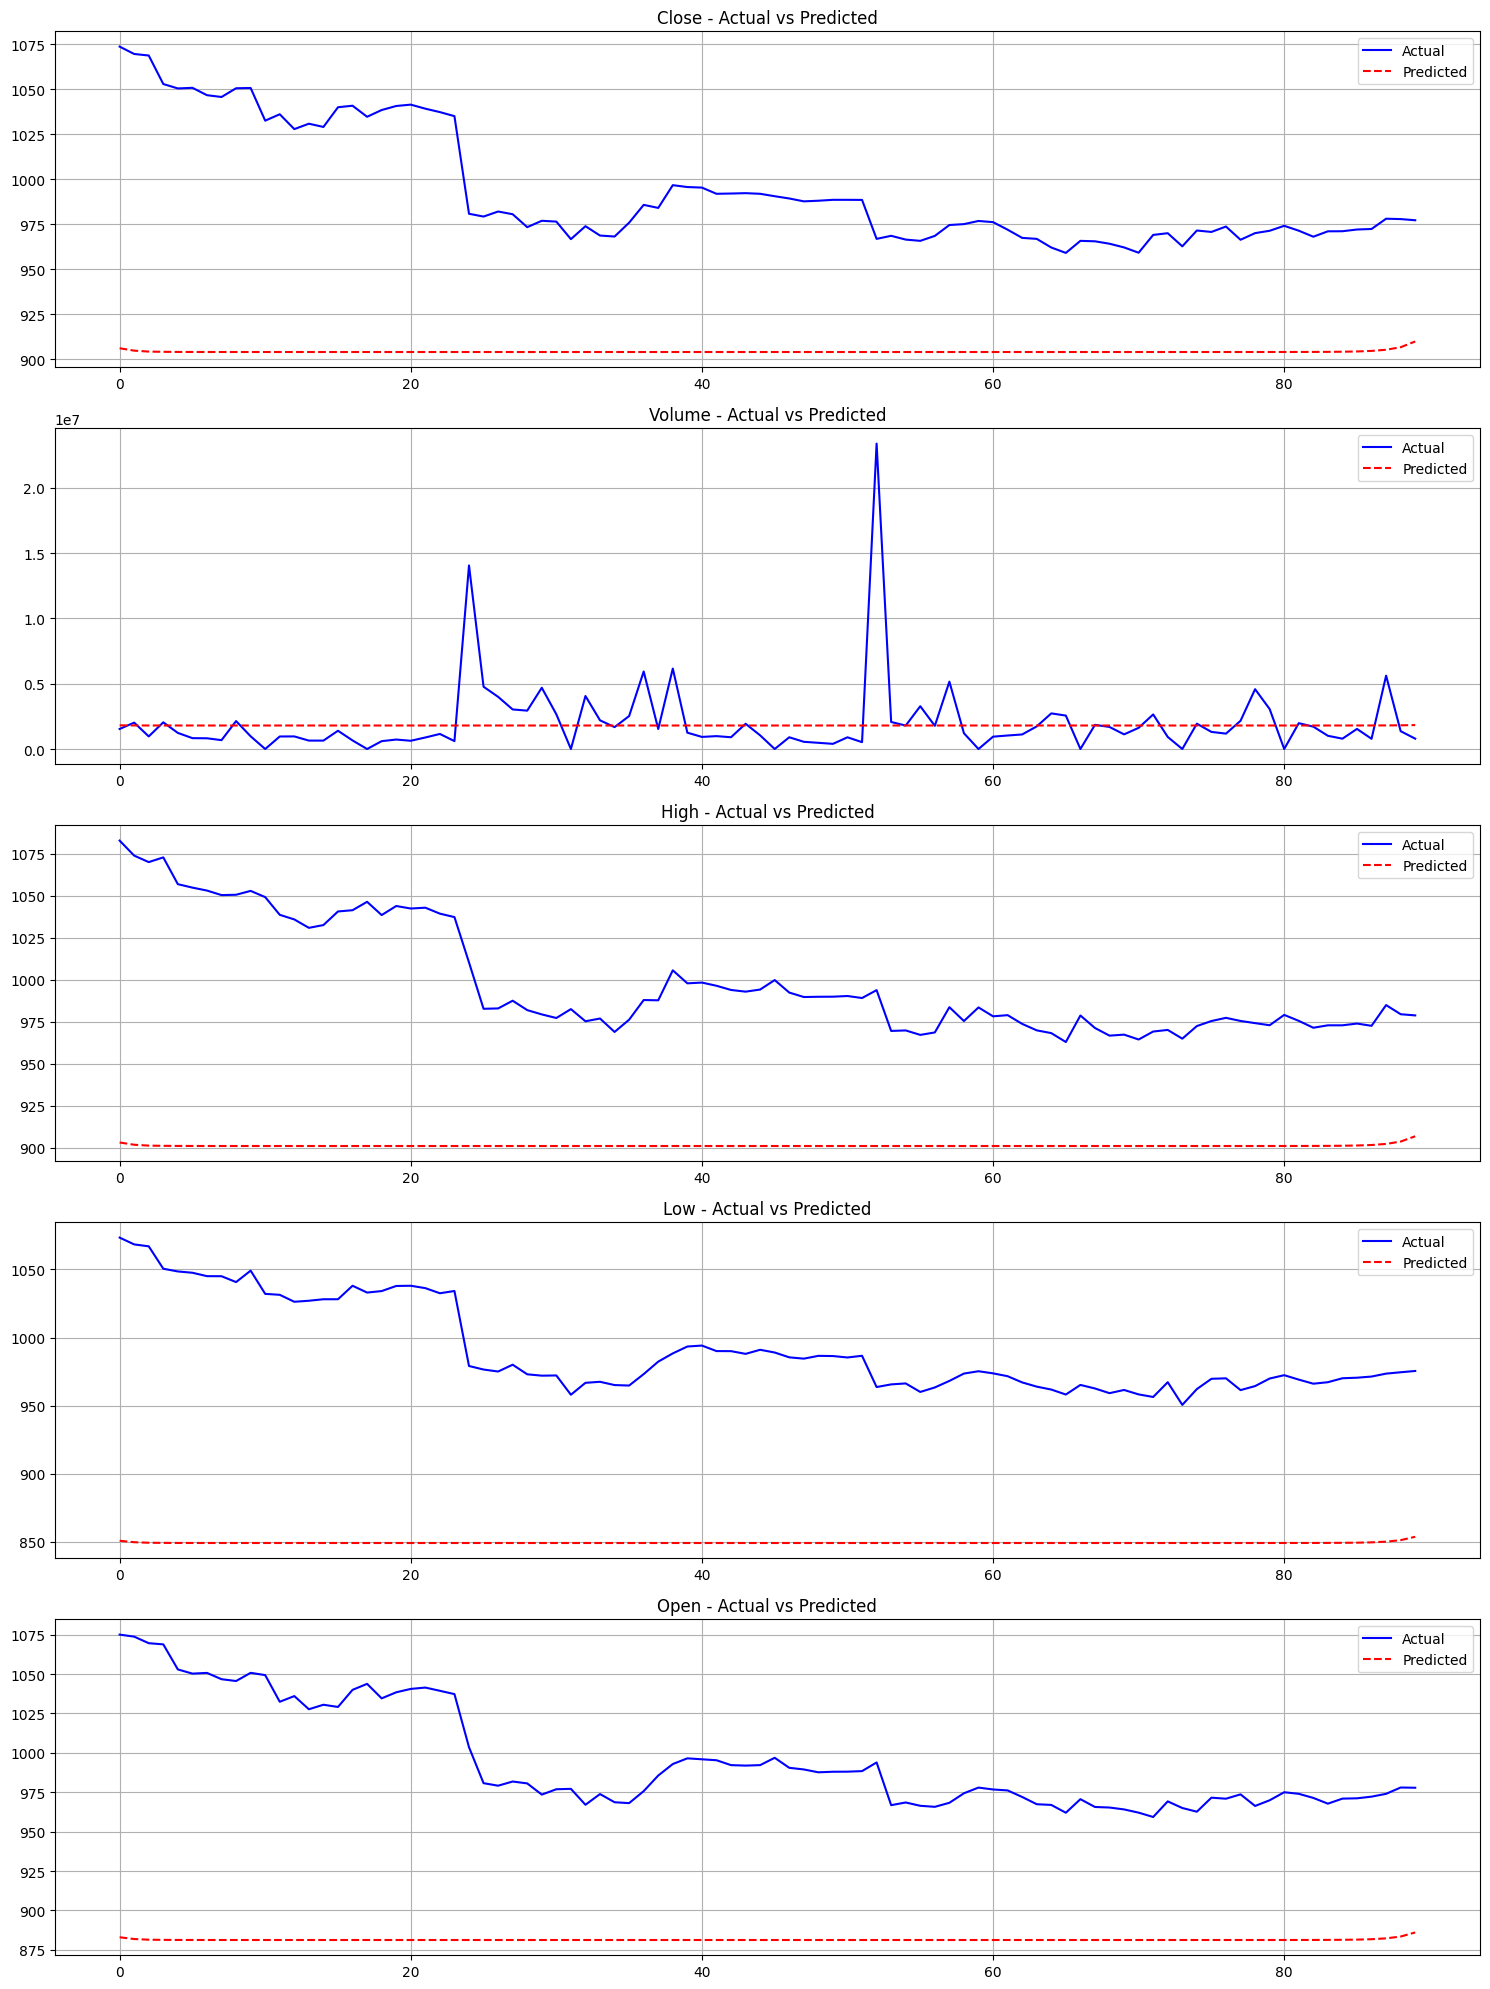

Epoch [30/30], Average Loss: 0.0646


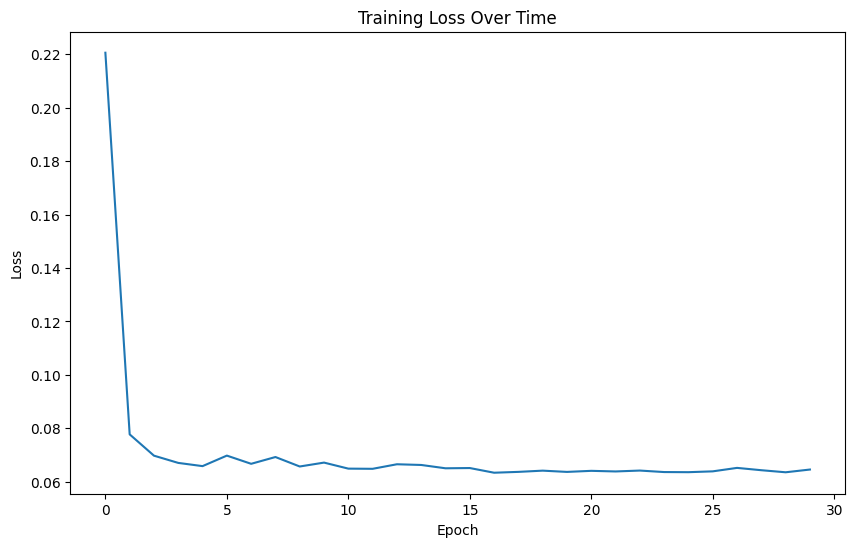

In [12]:
# main function
def main():
    # Hyperparameters
    SEQUENCE_LENGTH = 90
    HIDDEN_DIM = 512
    LATENT_DIM = 512
    NUM_TIMESTEPS = 500
    BATCH_SIZE = 64
    NUM_EPOCHS = 30
    LEARNING_RATE = 0.001

    # Fetch and preprocess data
    df = fetch_stock_data('AAPL', start_date='2023-06-01', end_date='2024-12-31', interval='1h')
    feature_names = df.columns.tolist()

    # Normalize data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Split data into train and test
    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    # Create datasets and dataloaders
    train_dataset = StockDataset(train_data, SEQUENCE_LENGTH)
    test_dataset = StockDataset(test_data, SEQUENCE_LENGTH)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = EnhancedDVA(
        input_dim=scaled_data.shape[1],
        hidden_dim=HIDDEN_DIM,
        latent_dim=LATENT_DIM,
        seq_length=SEQUENCE_LENGTH,
        num_timesteps=NUM_TIMESTEPS,
        device=device
    ).to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train model with visualization
    train_dva_with_visualization(
        model,
        train_loader,
        test_loader,
        optimizer,
        NUM_EPOCHS,
        device,
        feature_names,
        scaler
    )

    return model, scaler

if __name__ == "__main__":
    model, scaler = main()

